# Cluster Validation by Predition Strength
The prediction strength approach looks at the problem of identifying the optimal number of clusters from a machine learning point of view.
* Split the dataset into training (X_tr) and test (X_te) sets.
* Run the clustering algorithm on both sets using a certain value of k (the number of clusters).
* Create a co-membership matrix D[C(X_tr, k), X_te] of size n_test x n_test, where  C(X_tr, k) is the clustering algorithm (k-means in our case) fitted to the training set.
* Set the ii’-th element of the co-membership matrix to 1 if elements i and i’ of the test set fall into the same cluster, set it to 0 otherwise.
* In order to measure how well the training set centroids predict co-memberships in the test set. For each pair of test observations that are assigned to the same test cluster (a value of 1 in the co-membership matrix), we determine whether they are also assigned to the same cluster based on the training set centroids.
* The prediction strength of the clustering C(., k) is defined as:

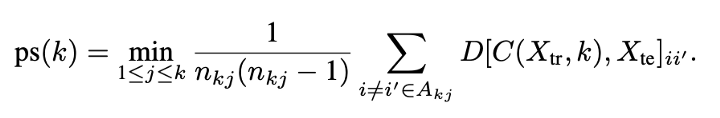

where n_kj is the number of observations in the j-th cluster.
* For each of the test clusters, we calculate the proportion of observation pairs in that cluster that are also assigned to the same cluster using the training set centroids. The prediction strength is the minimum of this quantity over the k test clusters.
* We run steps 2–7 of the algorithm described above for all the considered cluster sizes. Then, we select the maximum cluster size for which the prediction strength is above a certain threshold. Experiments ran by the authors suggest 0.8–0.9 as a good value for the threshold.

In [1]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from scipy.spatial import distance
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

## Generating Data

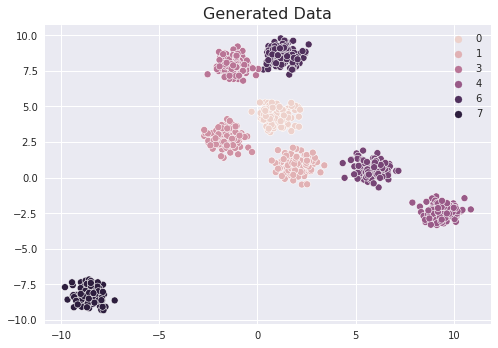

In [2]:
x, y = make_blobs(n_samples=1000, centers=8, random_state=0, cluster_std=0.5)

ax = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y)
ax.set_title('Generated Data', fontsize=16);

## Elbow Plot

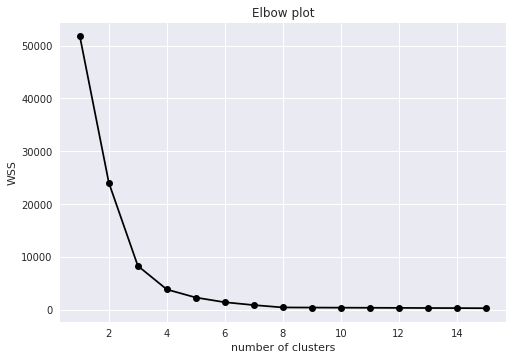

In [3]:
clusters = range(1, 16)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(x)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

## Prediction Strength

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)


def get_closest_centroid(obs, centroids):
    min_distance = float('inf')
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

def get_prediction_strength(k, train_centroids, x_test, test_labels):
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

  0%|          | 0/15 [00:00<?, ?it/s]

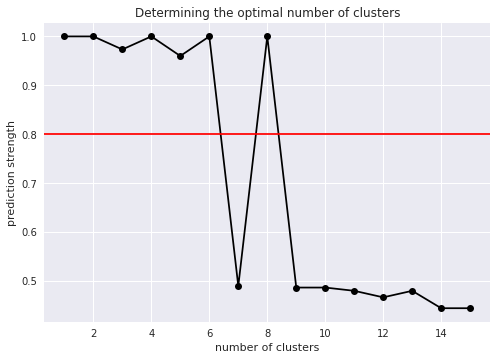

In [5]:
strengths = []
for k in tqdm(clusters):
    model_train = KMeans(n_clusters=k, random_state=0).fit(x_train)
    model_test = KMeans(n_clusters=k, random_state=0).fit(x_test)
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, x_test, model_test.labels_)
    strengths.append(pred_str)

_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

**8 is he maximum cluster size for which the prediction strength is above 0.8~0.9**

## Reference
[Cluster Validation by Prediction Strength](https://gwalther.su.domains/predictionstrength.pdf)
